# Estimation of the number of quiescent cells

Adding intra and interexperimental error. In the future maybe better do bootstrapping.

In [18]:
import pandas as pd
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
exec(open('settings.py').read(), globals())

In [19]:
cell_numbers = pd.read_csv('../data/cell_number_data.csv')
outgrowth = pd.read_csv('../data/outgrowth.csv')

In [20]:
lcell = 13.2
lcell_sem = 0.1

In [21]:
L0 = 800.0

In [22]:
cell_numbers = cell_numbers.query('pos > -@L0')

In [23]:
cell_numbers['quiescent'] = cell_numbers['SOX2'] - cell_numbers['PCNA']

In [31]:
cell_numbers_space_mean = cell_numbers[['ID', 'time', 'quiescent']].groupby('ID').agg({'time': ['mean'], 'quiescent': ['mean', 'sem']})

In [32]:
cell_numbers_mean = cell_numbers_space_mean.groupby([('time', 'mean')]).agg({('quiescent', 'mean'): ['mean', 'sem'], ('quiescent', 'sem'): ['mean']})

In [33]:
cell_numbers_mean['quiescent_delta'] = cell_numbers_mean['quiescent', 'mean', 'sem'] + cell_numbers_mean['quiescent', 'sem', 'mean']
cell_numbers_mean.index.name = 'time'

In [34]:
cell_numbers_mean['outgrowth'] = outgrowth.groupby('time').mean()['length']
cell_numbers_mean['outgrowth_sem'] = outgrowth.groupby('time').sem()['length']

In [35]:
for i, row in cell_numbers_space_mean.iterrows():
    cell_numbers_space_mean.loc[i, 'outgrowth'] =     float(outgrowth.groupby('time').mean().loc[int(row['time'])])
    cell_numbers_space_mean.loc[i, 'outgrowth_sem'] = float(outgrowth.groupby('time').sem()['length'].loc[int(row['time'])])
cell_numbers_space_mean

quiescent           time    outgrowth outgrowth_sem
          mean       sem mean                           
ID                                                      
0D_1  4.000000  1.080123    0     0.000000      0.000000
0D_2  2.714286  0.892143    0     0.000000      0.000000
0D_3  5.142857  1.121830    0     0.000000      0.000000
3D_1  3.500000  0.823754    3   163.285714     20.836911
3D_2  1.416667  0.483960    3   163.285714     20.836911
3D_3  1.000000  0.308607    3   163.285714     20.836911
4D_1  0.200000  0.133333    4   451.750000     41.292402
4D_2  0.923077  0.287820    4   451.750000     41.292402
4D_3  1.066667  0.358126    4   451.750000     41.292402
6D_1  0.350000  0.150000    6  1278.500000     56.769899
6D_2  0.238095  0.117610    6  1278.500000     56.769899
6D_3  0.307692  0.307692    6  1278.500000     56.769899
8D_1  0.705882  0.340466    8  2257.250000     72.342872
8D_2  0.529412  0.228770    8  2257.250000     72.342872
8D_3  1.166667  0.440959    8  2257.250000     72.342872

In [36]:
Nq = pd.DataFrame(index = cell_numbers_mean.index)
Nq['mean'] = (cell_numbers_mean['outgrowth'] + L0) / lcell * cell_numbers_mean['quiescent', 'mean', 'mean']
Nq['delta'] = Nq['mean'] * (lcell_sem / lcell + cell_numbers_mean['outgrowth_sem'] / cell_numbers_mean['outgrowth'] + cell_numbers_mean['quiescent', 'mean', 'sem'] / cell_numbers_mean['quiescent', 'mean', 'mean'])
Nq.loc[0, 'delta'] = Nq.loc[0, 'mean'] * ((lcell_sem / lcell + float(cell_numbers_mean.loc[0, ('quiescent', 'mean', 'sem')]) / cell_numbers_mean.loc[0, ('quiescent', 'mean', 'mean')]))

In [38]:
Nq

,mean,delta
time,,
0,239.538240,44.328161
3,143.925265,75.889197
4,69.217463,32.282615
6,47.017536,7.580782
8,185.439258,51.345679


## Check for significant differences

Let $N_q$ be the total number of quiescent cells in the spatial zone reaching from $-800\mu m$ to the posterior tip of the spinal cord and $l_{cell}$ the anteroposterior length of the cells, $N_{q,s}$ the mean number of quiescent cells per cross section and $L$ the outgrowth of the spinal cord and $L_0$ the source zone length. Then, the following euqation holds:
\begin{align}
N_q = N_{q,s} \frac{L + L_0}{l_{cell}}
\end{align}
As $l_{cell}$ is constant (Rodrigo Albors, Tazaki et al., eLife, 2015) we test if 
\begin{align}
N_q \cdot l_{cell} = N_{q,s} (L + L_0)
\end{align}
is significantly different to infer if $N_q$ is significantly different.

In [58]:
day = dict()
for time in Nq.index:
    day[time] = sp.array(cell_numbers_space_mean[cell_numbers_space_mean['time', 'mean'] == time]['quiescent', 'mean'])
    day[time] = day[time] * (float(outgrowth.groupby('time').mean().loc[time]) + L0)

ttest vs day0

In [67]:
for time in Nq.index:
    print 'Day 0 vs Day {0}: p = {1:.2f}'.format(time, sp.stats.ttest_ind(day[0], day[time]).pvalue)

Day 0 vs Day 0: p = 1.00
Day 0 vs Day 3: p = 0.25
Day 0 vs Day 4: p = 0.03
Day 0 vs Day 6: p = 0.01
Day 0 vs Day 8: p = 0.43


## Plot

In [71]:
from matplotlib.markers import TICKDOWN

def significance_bar(start,end,height,displaystring,linewidth = 1,markersize = 3,boxpad  =0.3,fontsize = 12,color = 'k'):
    # draw a line with downticks at the ends
    plt.plot([start,end],[height]*2,'-',color = color,lw=linewidth,marker = TICKDOWN,markeredgewidth=linewidth,markersize = markersize)
    # draw the text with a bounding box covering up the line
    plt.text(0.5*(start+end),height,displaystring,ha = 'center',va='center',size = fontsize)

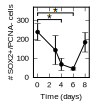

In [85]:
fig, ax = plt.subplots(1, figsize = (1, 31.5/25.0))
ax.errorbar(Nq.index,\
            Nq['mean'],
            Nq['delta'],
            fmt = 'ko', ls = '-')

significance_bar(0, 4, 305.0, '*')
significance_bar(0, 6, 340.0, '*')

ax.set_xlim(-0.7, 8.7)
ax.set_ylim(0, 370)
ax.set_yticks(sp.arange(0, 350, 100))
ax.set_xlabel('Time (days)')
ax.set_ylabel('# SOX2+/PCNA- cells', labelpad = 8)
plt.savefig('../figure_plots/Fig2_total_number_quiescent.svg')
plt.show()